# Task 1 : Extrinsic Estimation (20 Points)

You are given 5 images in the `data/Images` folder, and their corresponding 2d-3d correspondences in `data/Correspondences`. Use this information with the Ceres Solver to optimize for the extrinsic of each image using Reprojection Loss.

### Camera Intrinsics:
`fx` = `fy` = 721.5
 
`cx` and `cy` : $\frac{width}{2}$ and $\frac{height}{2}$

### Format for Correspondences:
`px py X Y Z i`
where: `p_x` and `p_y` are the 2d image coordinates, and `X`, `Y` and `Z` are the coordinates of the 3d correspondence for the 2d coordinate, and `i` is the 3d point's index in the pointcloud (you can ignore i, just use the rest of the information as is).


### Resources:
http://ceres-solver.org/nnls_solving.html <br>
http://ceres-solver.org/nnls_modeling.html <br>
http://ceres-solver.org/nnls_tutorial.html <br>

In [37]:
## code here

# Task 2 : Two-View Geometry Task (35 Points)

### Note:  Use images in folder data_Q2  and the file `data_Q2/intrinsics.txt` has camera intrinsics 
### Don't use Opencv functions unless explicitly mentioned. 

<img src="data_Q2/first_img.jpg" alt="image 1" width="400"/>
<img src="data_Q2/second_img.jpg" alt="image 2" width="400"/>

### 1. Feature Extraction and Matching
   **Implement a function to detect and match feature points between two images using OpenCV's SIFT or ORB.**  
   Visualize the matched points and filter outliers using RANSAC. 
   
   Theory : How do you ensure that the matches are accurate, and what thresholding techniques do you apply?

### 2. Fundamental Matrix Estimation
   **Write a function `compute_fundamental_matrix` to estimate the fundamental matrix using the 8-point algorithm.**  
   Normalize the points before estimating and check the rank of the matrix. Explain why normalization is essential in this context.
   
   Extend this to include the 7-point algorithm, and compare the accuracy of the two methods on your matched points.

### 3. Epipolar Lines Visualization
   **Write a function to plot epipolar lines on both images given the estimated fundamental matrix.**  
   For each matched feature in the first image, compute and draw the corresponding epipolar line in the second image.

   Theory (not part of bonus) : What methods can you use to verify that the epipolar lines are accurate?

### 4. Epipole Computation
   **Implement a function to calculate the epipoles from the fundamental matrix.**  
   Verify their correctness by showing that epipolar lines intersect at these points.

   Theory : What happens to the epipole location if the fundamental matrix is rank-deficient, and how can you simulate this scenario?

### 5. Camera Pose from Fundamental Matrix
   **Write a function `camera_pose_from_fundamental` to compute the four possible camera poses (rotation `R` and translation `t`) from the fundamental matrix and intrinsic matrix `K`.**

   Theory (not part of bonus) : Explain why there are four possible solutions and how to verify which is the correct one.

### 6. Triangulation of 3D Points
   **Implement linear triangulation in a function `linear_triangulation` that takes the projection matrices and point correspondences to compute 3D points.**

   Visualize the triangulated points in 3D and describe how the accuracy of 3D points depends on the quality of the fundamental matrix and camera pose.

### 7. Cheirality Condition
   **Write a function `check_cheirality` to ensure that the triangulated 3D points satisfy the cheirality condition for a given camera pose.**

   Use this function to select the correct camera pose among the four possibilities by maximizing the number of points that satisfy the cheirality condition.


### 8. Fundamental Matrix Validation
   **Write a function `validate_fundamental_matrix` to validate the estimated fundamental matrix by checking the epipolar constraint for a set of matched points.**  
   Calculate the residual error for each point pair and analyze the overall error.

   Theory : What threshold should you use to determine if a point satisfies the constraint?

### 9. Camera Pose Visualization
   **Use a 3D plotting library to visualize the computed camera poses and triangulated points in 3D space.**  
   Write a function that takes in camera poses and 3D points and plots them.

   Experiment with different camera poses and triangulated points to observe how pose selection affects the scene structure.

### 10. Error Analysis for Two-view Geometry
   **Implement a function to calculate and plot the reprojection error for triangulated 3D points.**  
   Measure the difference between original 2D points and the reprojected points on both images.

   Theory : How does this error analysis help in refining the camera pose selection?


### Bonus : All theory questions are part of bonus unless mentioned explicitly. (15 Points)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
from scipy.linalg import null_space

def normalize_points(points):
    mean = np.mean(points, axis=0)
    std = np.std(points)
    transform = np.array([
        [1/std, 0, -mean[0]/std],
        [0, 1/std, -mean[1]/std],
        [0, 0, 1]
    ])
    
    homogeneous_points = np.hstack((points, np.ones((points.shape[0], 1))))
    normalized = (transform @ homogeneous_points.T).T
    return normalized[:, :2], transform

def compute_fundamental_matrix(points1, points2):
    norm_points1, transform1 = normalize_points(points1)
    norm_points2, transform2 = normalize_points(points2)

    A = np.array([
        [x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1]
        for (x1, y1), (x2, y2) in zip(norm_points1, norm_points2)
    ])

    _, _, Vh = np.linalg.svd(A)
    F = Vh[-1].reshape(3, 3)

    U, S, Vh = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vh
    F = transform2.T @ F @ transform1
    
    return F

def match_features(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = sorted(matcher.match(des1, des2), key=lambda x: x.distance)[:400]
    
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 4.0)
    inliers = mask.ravel().astype(bool)
    
    return points1, points2, points1[inliers], points2[inliers]

def plot_matches(img1, img2, points1, points2, inlier_points1=None, inlier_points2=None):
    combined_img = np.hstack((img1, img2))
    points2_shifted = points2.copy()
    points2_shifted[:, 0] += img1.shape[1]

    plt.figure(figsize=(15, 10))
    plt.imshow(combined_img, cmap='gray')
    plt.axis('off')

    for pt1, pt2 in zip(points1, points2_shifted):
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'y-', linewidth=0.5)

    if inlier_points1 is not None and inlier_points2 is not None:
        inlier_points2_shifted = inlier_points2.copy()
        inlier_points2_shifted[:, 0] += img1.shape[1]
        
        for pt1, pt2 in zip(inlier_points1, inlier_points2_shifted):
            plt.scatter([pt1[0], pt2[0]], [pt1[1], pt2[1]], c='cyan', s=40, edgecolors='blue')
            plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=1)

    plt.show()

def plot_epipolar_line(img, line, point, height, width):
    if abs(line[1]) < 1e-10:
        return
        
    y0 = -line[2] / line[1]
    yw = -(line[2] + line[0] * width) / line[1]
    
    x0 = -line[2] / line[0] if abs(line[0]) > 1e-10 else width
    xh = -(line[2] + line[1] * height) / line[0] if abs(line[0]) > 1e-10 else width
    
    points = []
    if 0 <= y0 <= height: points.append([0, y0])
    if 0 <= yw <= height: points.append([width, yw])
    if 0 <= x0 <= width: points.append([x0, 0])
    if 0 <= xh <= width: points.append([xh, height])
    
    if len(points) >= 2:
        points.sort(key=lambda x: x[0])
        plt.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], 'r-', alpha=0.5)
    
    if 0 <= point[0] < width and 0 <= point[1] < height:
        plt.scatter(point[0], point[1], c='cyan', s=40, edgecolors='blue')

def visualize_epipolar_geometry(img1, img2, points1, points2, F):
    epipole1 = null_space(F)[:, 0]
    epipole2 = null_space(F.T)[:, 0]
    
    epipole1 = epipole1 / epipole1[2]
    epipole2 = epipole2 / epipole2[2]
    
    lines1 = (F.T @ np.column_stack((points2, np.ones(points2.shape[0]))).T).T
    lines2 = (F @ np.column_stack((points1, np.ones(points1.shape[0]))).T).T
    
    height, width = img1.shape[:2]
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    for line, point in zip(lines1, points1):
        plot_epipolar_line(img1, line, point, height, width)
    if 0 <= epipole1[0] <= width and 0 <= epipole1[1] <= height:
        plt.plot(epipole1[0], epipole1[1], 'rx', markersize=10)

    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    for line, point in zip(lines2, points2):
        plot_epipolar_line(img2, line, point, height, width)
    if 0 <= epipole2[0] <= width and 0 <= epipole2[1] <= height:
        plt.plot(epipole2[0], epipole2[1], 'rx', markersize=10)

    plt.show()

def get_camera_poses(F, K):
    E = K.T @ F @ K
    U, S, Vh = np.linalg.svd(E)
    
    if np.linalg.det(U @ Vh) < 0:
        Vh = -Vh
        
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    R1 = U @ W @ Vh
    R2 = U @ W.T @ Vh
    t = U[:, 2]
    
    if np.linalg.det(R1) < 0:
        R1, t = -R1, -t
    if np.linalg.det(R2) < 0:
        R2, t = -R2, -t
    
    return [(R1, t), (R1, -t), (R2, t), (R2, -t)]

def triangulate_points(P1, P2, points1, points2):
    points_3d = []
    
    for (x1, y1), (x2, y2) in zip(points1, points2):
        A = np.zeros((4, 4))
        A[0] = x1 * P1[2] - P1[0]
        A[1] = y1 * P1[2] - P1[1]
        A[2] = x2 * P2[2] - P2[0]
        A[3] = y2 * P2[2] - P2[1]
        
        _, _, Vh = np.linalg.svd(A)
        point_3d = Vh[-1]
        points_3d.append(point_3d[:3] / point_3d[3])
    
    return np.array(points_3d)

def check_point_depth(points_3d, R, t, K):
    points_3d_transformed = (R @ points_3d.T + t.reshape(3, 1)).T
    valid_points = np.sum((points_3d[:, 2] > 0) & (points_3d_transformed[:, 2] > 0))
    return valid_points, points_3d

def select_best_pose_and_validate(poses, intrinsics, points1, points2, F):
    P1 = intrinsics @ np.hstack((np.eye(3), np.zeros((3, 1))))
    best_pose = None
    max_valid_points = 0
    best_points_3d = None
    
    for R, t in poses:
        P2 = intrinsics @ np.hstack((R, t.reshape(3, 1)))
        points_3d = triangulate_points(P1, P2, points1, points2)
        valid_points = check_cheirality(points_3d, R, t)
        
        if valid_points > max_valid_points:
            max_valid_points = valid_points
            best_pose = (R, t)
            best_points_3d = points_3d

    F_error = validate_fundamental_matrix(F, points1, points2)
    return best_pose[0], best_pose[1], best_points_3d, F_error

def visualize_3d(points_3d, R, t):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)

    camera1_center = np.zeros(3)
    camera2_center = -R.T @ t

    camera1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    camera2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    camera1 = camera1.rotate(np.eye(3)).translate(camera1_center)
    camera2 = camera2.rotate(R.T).translate(camera2_center)

    o3d.visualization.draw_geometries([pcd, camera1, camera2])

def check_cheirality(points_3d, R, t):
    transformed_points = (R @ points_3d.T + t.reshape(3, 1)).T
    valid_points = np.sum((points_3d[:, 2] > 0) & (transformed_points[:, 2] > 0))
    return valid_points

def validate_fundamental_matrix(F, points1, points2):
    points1_h = np.column_stack((points1, np.ones(points1.shape[0])))
    points2_h = np.column_stack((points2, np.ones(points2.shape[0])))

    errors = np.abs(np.sum(points2_h * (F @ points1_h.T).T, axis=1))
    return errors.mean()

def calculate_reprojection_error(points_3d, points_2d, P):
    points_3d_homogeneous = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    reprojected_points = (P @ points_3d_homogeneous.T).T
    reprojected_points /= reprojected_points[:, 2:3]
    return np.linalg.norm(points_2d - reprojected_points[:, :2], axis=1)

def plot_reprojected_points(img, original_points, reprojected_points, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.scatter(original_points[:, 0], original_points[:, 1], color='red', label='Original Points', s=30)
    plt.scatter(reprojected_points[:, 0], reprojected_points[:, 1], color='blue', label='Reprojected Points', s=30)
    
    for orig, reproj in zip(original_points, reprojected_points):
        plt.plot([orig[0], reproj[0]], [orig[1], reproj[1]], color='yellow', linewidth=0.5)

    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

1. Extracting and matching features...
 - Total matches found: 400
 - Inliers after RANSAC: 56
2. Estimating the fundamental matrix...
 - Fundamental matrix computed.
 - Matrix rank: 2 (should be 2)
3. Visualizing epipolar geometry...


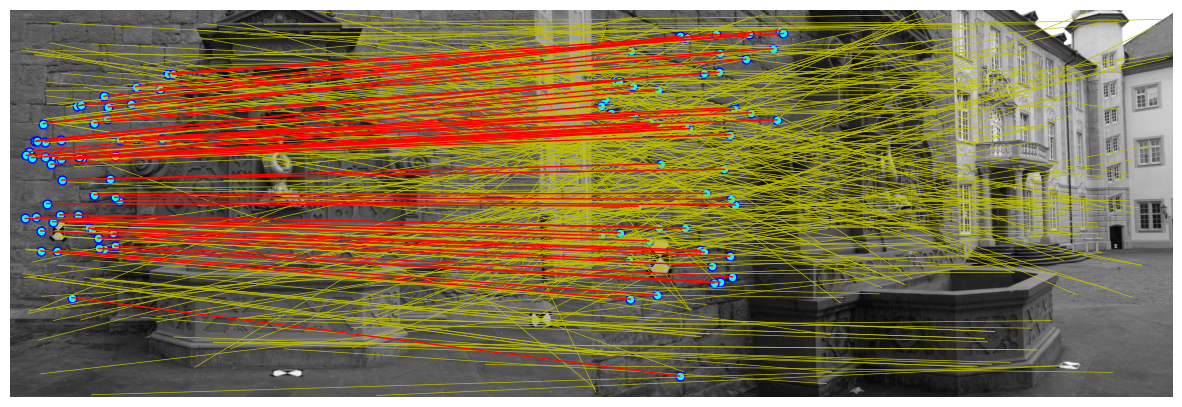

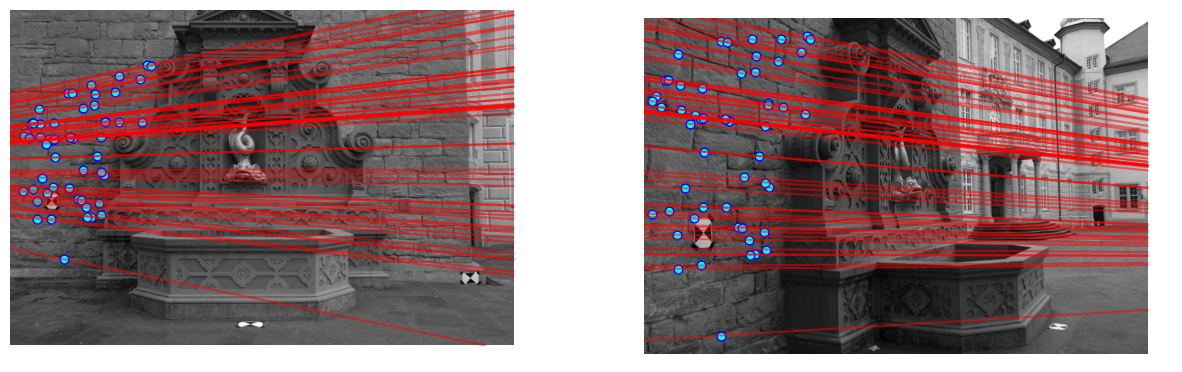

 - Epipolar lines drawn.
4. Computing camera poses...
 - Found 4 possible camera poses.
5. Selecting the best camera pose using the cheirality condition...
 - Best pose selected. Valid points: 56
6. Validating the fundamental matrix...
 - Residual mean error: 0.0009
7. Visualizing the 3D reconstruction...
 - 3D points visualized.
10. Performing error analysis for two-view geometry...
 - Calculating reprojection errors...


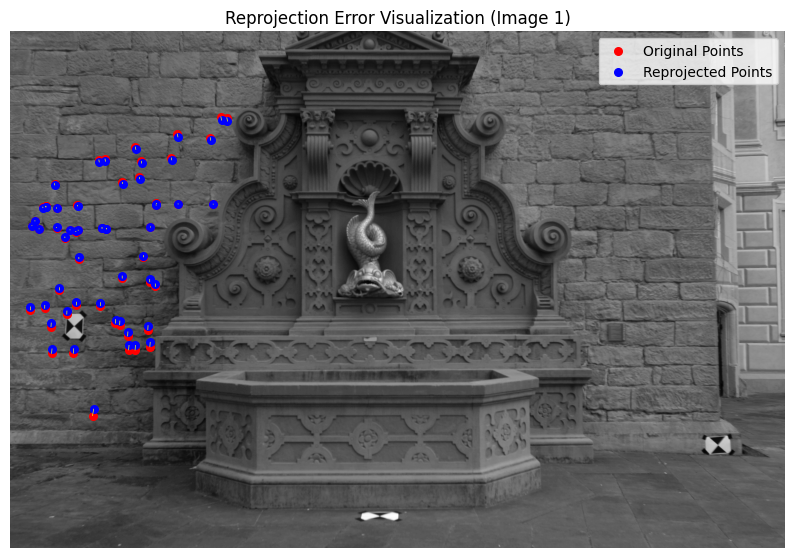

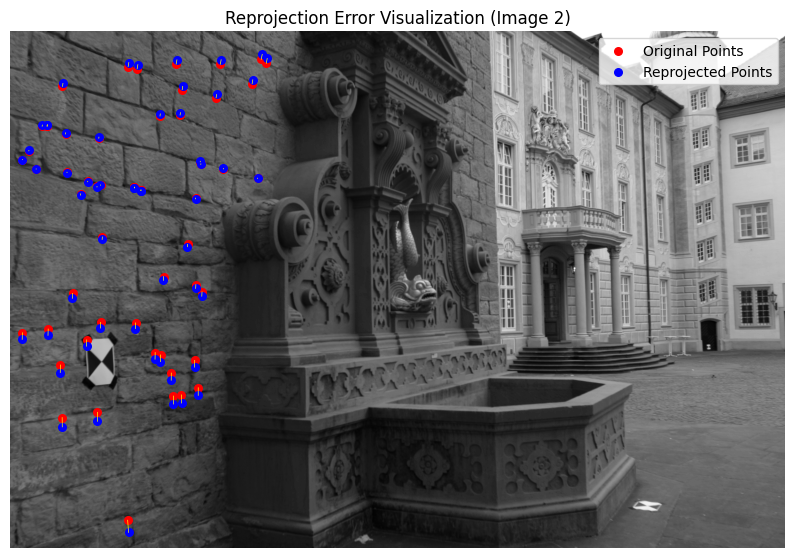

In [39]:
img1 = cv2.imread("data_Q2/first_img.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("data_Q2/second_img.jpg", cv2.IMREAD_GRAYSCALE)
intrinsics = np.loadtxt("data_Q2/intrinsics.txt")

print("1. Extracting and matching features...")
points1, points2, inlier_points1, inlier_points2 = match_features(img1, img2)
print(f" - Total matches found: {len(points1)}")
print(f" - Inliers after RANSAC: {len(inlier_points1)}")

print("2. Estimating the fundamental matrix...")
F = compute_fundamental_matrix(inlier_points1, inlier_points2)
print(" - Fundamental matrix computed.")
print(f" - Matrix rank: {np.linalg.matrix_rank(F)} (should be 2)")

print("3. Visualizing epipolar geometry...")
plot_matches(img1, img2, points1, points2, inlier_points1, inlier_points2)
visualize_epipolar_geometry(img1, img2, inlier_points1, inlier_points2, F)
print(" - Epipolar lines drawn.")

print("4. Computing camera poses...")
poses = get_camera_poses(F, intrinsics)
print(f" - Found {len(poses)} possible camera poses.")

print("5. Selecting the best camera pose using the cheirality condition...")
best_pose = None
max_valid_points = 0
best_points_3d = None

for R, t in poses:
    P1 = intrinsics @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = intrinsics @ np.hstack((R, t.reshape(3, 1)))
    points_3d = triangulate_points(P1, P2, inlier_points1, inlier_points2)
    valid_points, _ = check_point_depth(points_3d, R, t, intrinsics)

    if valid_points > max_valid_points:
        max_valid_points = valid_points
        best_pose = (R, t)
        best_points_3d = points_3d

R, t = best_pose
print(f" - Best pose selected. Valid points: {max_valid_points}")

print("6. Validating the fundamental matrix...")
residual_errors = []
for (x1, y1), (x2, y2) in zip(inlier_points1, inlier_points2):
    p1 = np.array([x1, y1, 1]).T
    p2 = np.array([x2, y2, 1]).T
    error = abs(p2.T @ F @ p1)
    residual_errors.append(error)

mean_error = np.mean(residual_errors)
print(f" - Residual mean error: {mean_error:.4f}")

print("7. Visualizing the 3D reconstruction...")
# visualize_3d(best_points_3d, R, t)
print(" - 3D points visualized.")

print("10. Performing error analysis for two-view geometry...")
P1 = intrinsics @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = intrinsics @ np.hstack((R, t.reshape(3, 1)))

print(" - Calculating reprojection errors...")
errors_img1 = calculate_reprojection_error(best_points_3d, inlier_points1, P1)
errors_img2 = calculate_reprojection_error(best_points_3d, inlier_points2, P2)

reprojected_points1 = (P1 @ np.hstack((best_points_3d, np.ones((best_points_3d.shape[0], 1)))).T).T
reprojected_points1 /= reprojected_points1[:, 2].reshape(-1, 1)

reprojected_points2 = (P2 @ np.hstack((best_points_3d, np.ones((best_points_3d.shape[0], 1)))).T).T
reprojected_points2 /= reprojected_points2[:, 2].reshape(-1, 1)

plot_reprojected_points(img1, inlier_points1, reprojected_points1[:, :2], "Reprojection Error Visualization (Image 1)")
plot_reprojected_points(img2, inlier_points2, reprojected_points2[:, :2], "Reprojection Error Visualization (Image 2)")